In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
import re

In [ ]:
# Load the dataset
dataset_url = 'unsmile_dataset.txt'
data = pd.read_csv(dataset_url, sep='\t', encoding='utf-8')

In [ ]:
# Merge labels
label_columns = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭']

def extract_labels(row):
    return [label_columns[i] for i in range(len(label_columns)) if row[i+1] == 1]

data['labels'] = data.apply(extract_labels, axis=1)

data['multi_class_label'] = data[label_columns].idxmax(axis=1)

# text cleaning
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z가-힣0-9\s]", "", text)
    return text.strip()

# 'comments' column cleaning
data['문장'] = data['문장'].apply(clean_text)


In [ ]:
# Encode Label & Make label column
id2label = {k:v for k, v in enumerate(data['multi_class_label'].unique())}
label2id = {v:k for k, v in id2label.items()}

data['labels'] = data['multi_class_label'].map(label2id)

In [ ]:
# Split and Make Dataset
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

In [ ]:
# Tokenize Dataset
tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')
def tokenize_data(data):
    encoded = tokenizer(
        data['문장'],
        truncation=True
    )
    encoded['labels'] = data['labels']
    return encoded

tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/14993 [00:00<?, ? examples/s]

Map:   0%|          | 0/1874 [00:00<?, ? examples/s]

Map:   0%|          | 0/1875 [00:00<?, ? examples/s]

In [ ]:
# Load Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest'    # pad to longest sequence in batch
)

In [ ]:
# Function to compute metrics
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    precision = precision_score(p.label_ids, preds, average='weighted')
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision}

In [ ]:
# Load arguments
training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=8,
        weight_decay=.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        evaluation_strategy='steps',
        eval_steps=300,
        save_strategy='steps',
        save_steps=300,
        logging_strategy='steps',
        logging_steps=500,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        lr_scheduler_type='cosine',
        warmup_ratio=0.1
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Load & Train model

model = AutoModelForSequenceClassification.from_pretrained('monologg/koelectra-base-v3-discriminator', id2label=id2label, label2id=label2id)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision
300,No log,2.015422,0.286019,0.164023,0.116152
600,2.054200,1.669452,0.419957,0.371806,0.438647
900,2.054200,1.325350,0.593917,0.568231,0.565229
1200,1.535800,1.055344,0.686233,0.677568,0.684126
1500,1.011000,0.972308,0.704376,0.696358,0.700317
1800,1.011000,0.852842,0.732657,0.724651,0.728620
2100,0.833200,0.868750,0.735859,0.726799,0.724425
2400,0.833200,0.919721,0.731590,0.728956,0.733828
2700,0.623200,0.853170,0.744931,0.742162,0.745885
3000,0.546100,0.908782,0.742796,0.741330,0.742397


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

TrainOutput(global_step=7504, training_loss=0.5587675053157659, metrics={'train_runtime': 2182.2597, 'train_samples_per_second': 54.963, 'train_steps_per_second': 3.439, 'total_flos': 3639799055107740.0, 'train_loss': 0.5587675053157659, 'epoch': 8.0})

In [ ]:
# Evaluate the final model on the test set
test_results = trainer.evaluate(tokenized_test_dataset)

print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")
print(f"Test Precision: {test_results['eval_precision']}")

Test Accuracy: 0.7722666666666667
Test F1 Score: 0.7716627046457669
Test Precision: 0.7714575678803918


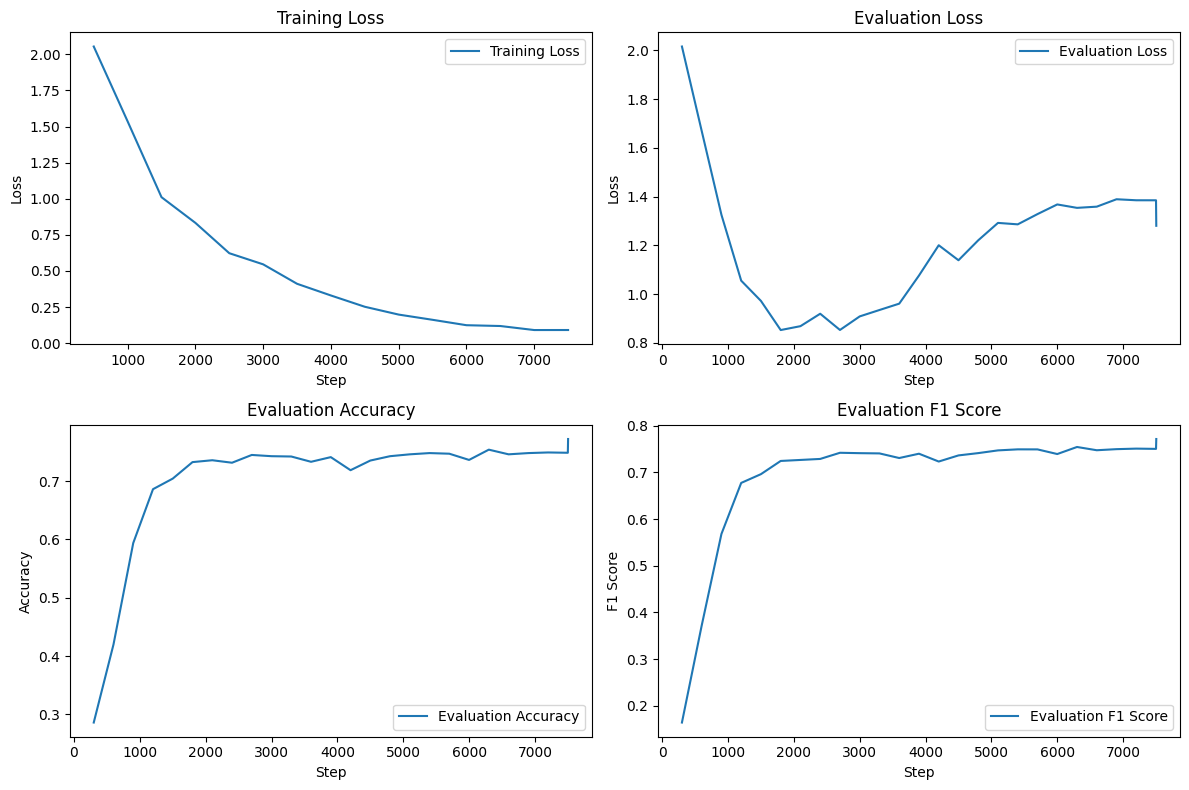

In [ ]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Creating the plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(eval_steps, eval_f1, label='Evaluation F1 Score')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Evaluation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

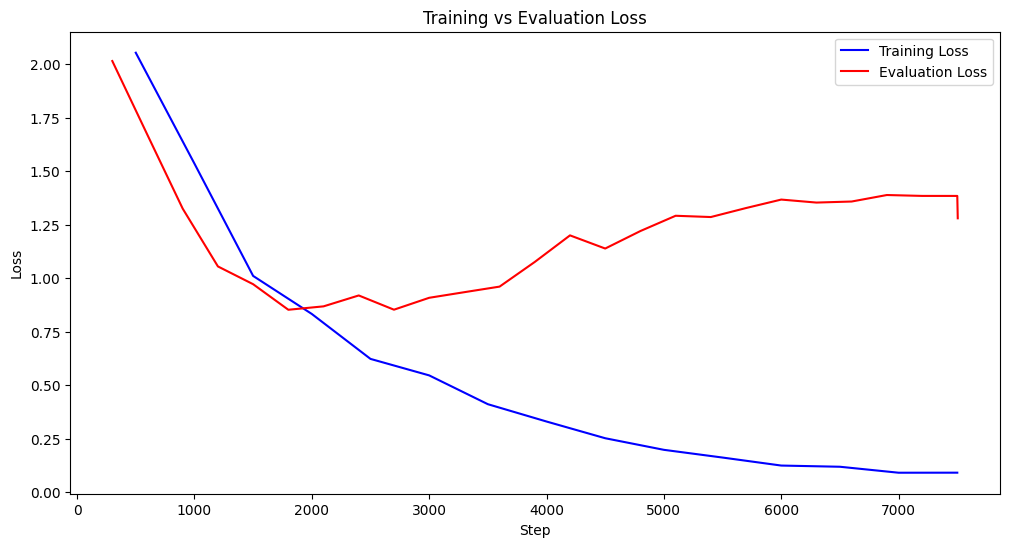

In [ ]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Plotting Loss (Training and Evaluation on the same graph)
plt.figure(figsize=(12, 6))

plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=60d35cf9daf49d018ff86eb5bd4e775d9c492dfae6caebff4c54ecd7a1501bc3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import matplotlib.font_manager as fm
import torch

abusive_indices = test_data[test_data['multi_class_label'] == '악플/욕설'].index.tolist()

# '악플/욕설' 라벨이 있는 데이터 10개 출력
for idx in abusive_indices[:10]:
    text_str = test_data.loc[idx, '문장']  # '문장' 열에 텍스트가 저장되어 있습니다.
    label = test_data.loc[idx, 'multi_class_label']  # 'multi_class_label' 열에서 라벨을 가져옵니다.
    print(f"Index: {idx}, Text: {text_str}, Label: {label}")

Index: 1323, Text: 주작글 같긴 한데 도와줬어야 드립치는 새끼들 존나 좆같네, Label: 악플/욕설
Index: 13091, Text: 또 다른 기득권 이용자들은 호구냐 통행료 내려, Label: 악플/욕설
Index: 409, Text: 게이건 성소수자건 코로나 상황에서 여기조기 뻔질나게 돌아다닌게 문제지 뭘 보호하고 뭘 우려되 성소수자는 코로나도 대우받아야 하냐, Label: 악플/욕설
Index: 9445, Text: 성범죄 가장 많은 직군 1위, Label: 악플/욕설
Index: 18170, Text: 혐오와 차별대화사례는 사과할일이 아님 일그러진 자화상이니까 있는 그대로 민낯이 드러난거 개인정보 도용은 그냥 벌금도 내고 깜빵도 가세요 사과로 해결안됨, Label: 악플/욕설
Index: 5274, Text: 부사관 장교도 가지마 그럼 씨발, Label: 악플/욕설
Index: 15543, Text: 병원에서 저러고 다니면 환자들 놀라는건 당연하지 한국 병원에서 소복 입고 다녀봐라 쌍 욕 다 들었을꺼다, Label: 악플/욕설
Index: 4153, Text: 난 14살때부터 정치 관심 있었는데 애초에 난 책을 제대로 읽기 시작한 때부터 신자유주의자였음이명박 박근혜 노무현 김대중 문재인의 비리 과거 같은 거 전혀 관심 없음그냥 이새끼들 방향성만 본다, Label: 악플/욕설
Index: 7808, Text: 이런 폐기물이 일베쳐오고 랩업하고, Label: 악플/욕설
Index: 9152, Text: 씨발놈들 이기회 한몫 땡기겠다 이거구만, Label: 악플/욕설


In [ ]:
# 모델을 GPU로 이동
model = model.to('cuda')

# predict_proba 함수 수정
def predict_proba(texts):
    # 텍스트를 리스트로 받아 한 번에 처리
    encoded_texts = tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=512)
    encoded_texts = {k: v.to('cuda') for k, v in encoded_texts.items()}
    with torch.no_grad():
        outputs = model(**encoded_texts)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return predictions.to('cpu').numpy()

# LIME 설명 생성기를 멀티 클래스 라벨에 맞게 초기화
class_names = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
random_indices = np.random.choice(test_data.index, size=5, replace=False)
torch.cuda.empty_cache()


for idx in random_indices:
    sample_text = test_data.loc[idx]['문장']
    # LIME을 사용하여 예측 설명 생성
    exp = explainer.explain_instance(sample_text, predict_proba, num_features=6,labels=range(len(class_names)))
    # 설명 출력 (텍스트로 출력)
    print(f"Explanation for index {idx}:")
    for label in exp.available_labels():
        print(f"Label {class_names[label]}:")
        for feature, weight in exp.as_list(label=label):
            print(f"  {feature}: {weight}")

Explanation for index 13169:
Label 여성/가족:
  작업복입은: -0.00020274403438202623
  뒤에: -0.0001834488310012193
  새키: -0.000148910039878239
  원피스: -4.998338294439161e-05
Label 남성:
  새키: -0.00011684569108498791
  작업복입은: -0.00011628552716231959
  뒤에: -0.00011127596157442899
  원피스: -2.525529186962693e-05
Label 성소수자:
  작업복입은: -0.00010714469400221143
  새키: -0.00010334073720705057
  뒤에: -9.71027293746771e-05
  원피스: -2.5946379983788834e-05
Label 인종/국적:
  작업복입은: -0.1099858107151999
  뒤에: -0.10438379632124863
  원피스: -0.09233965917416381
  새키: -0.030088550721654877
Label 연령:
  작업복입은: -0.001074712617473482
  뒤에: -0.0010465522739609861
  새키: -0.001020215225196035
  원피스: -0.00023434597240545345
Label 지역:
  작업복입은: 0.11196142997698241
  뒤에: 0.10630026588693749
  원피스: 0.09278696442121977
  새키: 0.03196469713265114
Label 종교:
  새키: -0.00017746811667215145
  뒤에: -0.00015390426658558706
  작업복입은: -0.00015279058573978017
  원피스: -2.93673091871166e-05
Label 기타 혐오:
  작업복입은: -0.00013870167911240842
  뒤에: -0.000133825362

In [ ]:
# Save the explanation to an HTML file
exp.save_to_file('lime_explanation.html')

# Display the HTML file in Colab
from IPython.display import IFrame
IFrame(src='lime_explanation.html', width=700, height=300)